<a href="https://colab.research.google.com/github/LariouchOussama/Twitter-Sentiment-Analysis/blob/main/TwitterLSTM_Sentiment_Analysis_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis using **LSTM**



#**Sujet : analyse de sentiments**

Le traitement automatique de la langue est un domaine multidisciplinaire impliquant la
linguistique, l'informatique et l'intelligence artificielle. Il vise à créer des outils de traitement de
la langue naturelle pour diverses applications. Parmi ces applications, nous pouvons citer celles
qui relèvent du traitement des réseaux sociaux. Les sites de médias sociaux, tels que Twitter,
sont une source riche de nombreux types d'informations, notamment en matière de santé.
Ce projet consiste à développer des modèles de classification des sentiments (positive, negative
ou neutre) sur les réseaux sociaux avec trois architectures différentes (LSTM, BERT, et GPT),
et à évaluer le meilleur d’entre eux.


> Dataset est dans le site Kaggle:


**training.1600000.processed.noemoticon.csv**

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from google.colab import drive
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM

In [2]:
print(device_lib.list_local_devices())

drive.mount('/content/drive')
nltk.download('stopwords')

if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13263706110559021922
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18219283998870002399
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
column_names = ['Sentiment', 'ID', 'Date', 'Query', 'Person', 'Content']
df = pd.read_csv('drive/MyDrive/training.csv', encoding='latin-1', names=column_names)

df.head()

,Sentiment,ID,Date,Query,Person,Content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.Sentiment.value_counts()

0    800000
4    800000
Name: Sentiment, dtype: int64

In [5]:
df['Sentiment'] = df['Sentiment'].replace(4,1)

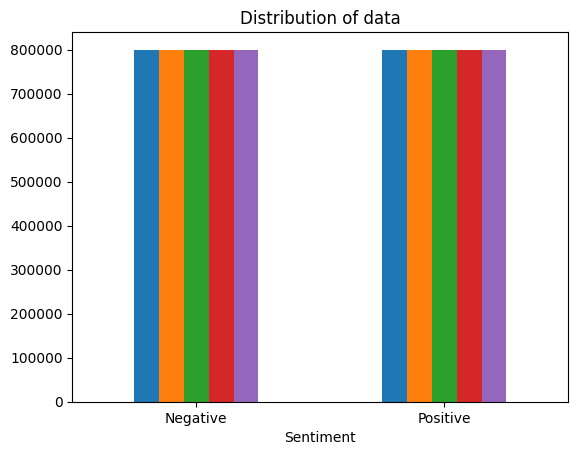

In [6]:


# Plotting the distribution for dataset.
ax = df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
Content, sentiment = list(df['Content']), list(df['Sentiment'])



In [7]:
df.shape


(1600000, 6)

In [8]:

frames = [df.head(5000), df.tail(5000)]
df = pd.concat(frames)
df.shape

(10000, 6)

In [12]:


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

def assign_labels_2(label):
    if label == 1:
        return 'positive'
    elif label == 0:
        return 'negative'



In [13]:
num_labels = 2

X = df['Content'].apply(preprocess_text)
y = df['Sentiment'].apply(assign_labels_2)

In [14]:
sentiment_counts = y.value_counts()
fig = px.bar(sentiment_counts, x=sentiment_counts.index, y=sentiment_counts.values, color=sentiment_counts.index)
fig.update_layout(title="Sentiment Distribution")
fig.show()

In [15]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [16]:

y = tf.keras.utils.to_categorical(y, 2)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
validation_num = 1000

X_validation, X_train = X_train[:validation_num], X_train[validation_num:]
y_validation, y_train = y_train[:validation_num], y_train[validation_num:]

In [19]:
X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((7000,), (1000,), (2000,), (7000, 2), (1000, 2), (2000, 2))

In [20]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_validation = tokenizer.texts_to_sequences(X_validation)
X_test = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max([len(x) for x in X_train])
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_validation = pad_sequences(X_validation, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [21]:
with tf.device('GPU'):
    model_rnn = Sequential()
    model_rnn.add(Embedding(1000, 32))
    model_rnn.add(SimpleRNN(32))
    model_rnn.add(Dense(2, activation='softmax'))

In [22]:
with tf.device('GPU'):
    epochs = 10
    model_rnn.compile(optimizer='adam',
                      loss= 'categorical_crossentropy',
                      metrics=['accuracy'])
    history_rnn = model_rnn.fit(X_train,
                                y_train,
                                epochs=epochs,
                                batch_size=64,
                                validation_data=(X_validation, y_validation))

Epoch 1/10
110/110 [==============================] - 20s 138ms/step - loss: 0.6648 - accuracy: 0.5936 - val_loss: 0.6155 - val_accuracy: 0.6530
Epoch 2/10
110/110 [==============================] - 4s 37ms/step - loss: 0.5120 - accuracy: 0.7534 - val_loss: 0.5693 - val_accuracy: 0.7000
Epoch 3/10
110/110 [==============================] - 4s 38ms/step - loss: 0.4163 - accuracy: 0.8070 - val_loss: 0.6167 - val_accuracy: 0.6910
Epoch 4/10
110/110 [==============================] - 6s 50ms/step - loss: 0.3270 - accuracy: 0.8570 - val_loss: 0.7132 - val_accuracy: 0.6740
Epoch 5/10
110/110 [==============================] - 4s 39ms/step - loss: 0.2660 - accuracy: 0.8861 - val_loss: 0.7993 - val_accuracy: 0.6780
Epoch 6/10
110/110 [==============================] - 3s 23ms/step - loss: 0.2165 - accuracy: 0.9071 - val_loss: 0.9286 - val_accuracy: 0.6760
Epoch 7/10
110/110 [==============================] - 2s 22ms/step - loss: 0.1846 - accuracy: 0.9231 - val_loss: 1.0820 - val_accuracy: 0.65

In [23]:
train_loss_rnn = history_rnn.history['loss']
validation_loss_rnn = history_rnn.history['val_loss']

train_acc_rnn = history_rnn.history['accuracy']
validation_acc_rnn = history_rnn.history['val_accuracy']

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=train_acc_rnn, mode='lines+markers', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=validation_acc_rnn, mode='lines+markers', name='Validation Accuracy'))

fig.update_layout(title="RNN Acuuracy",
                  xaxis_title="Epochs",
                  yaxis_title="Accuracy")
fig.show()

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=train_loss_rnn, mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=validation_loss_rnn, mode='lines+markers', name='Validation Loss'))

fig.update_layout(title="RNN Loss",
                  xaxis_title="Epochs",
                  yaxis_title="Loss")
fig.show()

In [26]:
test_predictions = model_rnn.predict(X_test)

predicted_labels = np.argmax(test_predictions, axis=1)

test_labels_1d = np.argmax(y_test, axis=1)

63/63 [==============================] - 0s 3ms/step


In [27]:
print(classification_report(test_labels_1d, predicted_labels))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1012
           1       0.64      0.70      0.67       988

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



In [28]:

with tf.device('GPU'):
    model_lstm = Sequential()
    model_lstm.add(Embedding(1000, 32))
    model_lstm.add(LSTM(32))
    model_lstm.add(Dense(2, activation='softmax'))

In [29]:
with tf.device('GPU'):
    epochs = 10
    model_lstm.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    history_lstm = model_lstm.fit(X_train,
                                  y_train,
                                  epochs=epochs,
                                  batch_size=64,
                                  validation_data=(X_validation, y_validation))

Epoch 1/10
110/110 [==============================] - 11s 60ms/step - loss: 0.6646 - accuracy: 0.6194 - val_loss: 0.5975 - val_accuracy: 0.6930
Epoch 2/10
110/110 [==============================] - 3s 24ms/step - loss: 0.5292 - accuracy: 0.7361 - val_loss: 0.5588 - val_accuracy: 0.7210
Epoch 3/10
110/110 [==============================] - 2s 17ms/step - loss: 0.4794 - accuracy: 0.7736 - val_loss: 0.5510 - val_accuracy: 0.7210
Epoch 4/10
110/110 [==============================] - 2s 14ms/step - loss: 0.4649 - accuracy: 0.7786 - val_loss: 0.5589 - val_accuracy: 0.7130
Epoch 5/10
110/110 [==============================] - 1s 13ms/step - loss: 0.4534 - accuracy: 0.7899 - val_loss: 0.5675 - val_accuracy: 0.7020
Epoch 6/10
110/110 [==============================] - 2s 14ms/step - loss: 0.4474 - accuracy: 0.7920 - val_loss: 0.5672 - val_accuracy: 0.7100
Epoch 7/10
110/110 [==============================] - 1s 8ms/step - loss: 0.4425 - accuracy: 0.7954 - val_loss: 0.5727 - val_accuracy: 0.7000

In [30]:
train_loss_lstm = history_lstm.history['loss']
validation_loss_lstm = history_lstm.history['val_loss']

train_acc_lstm = history_lstm.history['accuracy']
validation_acc_lstm = history_lstm.history['val_accuracy']

In [31]:


fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=train_acc_lstm, mode='lines+markers', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=validation_acc_lstm, mode='lines+markers', name='Validation Accuracy'))

fig.update_layout(title="LSTM Acuuracy",
                  xaxis_title="Epochs",
                  yaxis_title="LSTM Accuracy")
fig.show()



In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=train_loss_lstm, mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=validation_loss_lstm, mode='lines+markers', name='Validation Loss'))

fig.update_layout(title="LSTM Loss",
                  xaxis_title="Epochs",
                  yaxis_title="LSTM Loss")
fig.show()

In [33]:

test_predictions = model_lstm.predict(X_test)

predicted_labels = np.argmax(test_predictions, axis=1)

test_labels_1d = np.argmax(y_test, axis=1)

63/63 [==============================] - 0s 2ms/step


In [34]:
print(classification_report(test_labels_1d, predicted_labels))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1012
           1       0.69      0.77      0.73       988

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.71      2000

